In [2]:
import os
from pathlib import Path
from astropy.io import fits
import numpy as np
import pandas as pd

#pad naar de betreffende metingen, deze moet veranderd worden
path = "C:/Users/Arnau/Documents/NS Practicum 2/Zonnefysica Experiment/map/"
files =  [ p for p in Path(path).glob('*.fit') ]

data_dict = dict()
for file in files:
    data_dict[os.path.basename(file)] = fits.getdata(file)

data_headers = dict()
for x in data_dict.keys():
    data_headers[x] = fits.getheader(path + x)

In [3]:
def import_files(path, filename):
    '''
    Import files in the syntax that I used in the notebook. That is, choose the path that contains
    all the fit files, then for the filename choose something like bias* to obtain all bias files
    as a dictionary that can be accessed by filename 
    '''
    files =  [ p for p in Path(path).glob(filename) ]
    file_dict = dict()
    for file in files:
        file_dict[os.path.basename(file)] = fits.getdata(file) # key of the dict is the filename.

    headers_dict = dict()
    for x in file_dict.keys():
        headers_dict[x] = fits.getheader(path + x)

    return file_dict, headers_dict 

bias_dict, bias_headers = import_files(
    path="C:/Users/Arnau/Documents/NS Practicum 2/Zonnefysica Experiment/map/",
    filename="bias*"
)
bias_dict

{'bias-001.fit': array([[264, 279, 264, ..., 259, 257, 244],
        [266, 287, 275, ..., 279, 280, 277],
        [254, 279, 253, ..., 284, 263, 299],
        ...,
        [260, 276, 271, ..., 273, 269, 262],
        [265, 274, 246, ..., 288, 270, 266],
        [247, 277, 253, ..., 249, 262, 274]], dtype=uint16)}

Flat

In [4]:
def stack(values):
    return  np.median( [ x for x in values ], axis=0 )

flat = fits.getdata("flat-0001.fit" )
light = fits.getdata("skyspectrum zenit-0001.fit" )

bias_master = stack( bias_dict.values() )

light_sum_before = np.sum (light, axis=0)
light_sum = np.sum( light - bias_master, axis=0)

flat_sum_before = np.sum (flat, axis=0)
flat_sum = np.sum( flat - bias_master, axis=0)

flat_scaled = flat_sum / np.median(flat_sum)
light_scaled = light_sum / flat_scaled
flat_scaled

array([0.16589199, 0.16580829, 0.16631787, ..., 0.99732626, 1.00387401,
       0.0060679 ])

vega

In [32]:
vega_light = fits.getdata("Vega-0005_2s.fit" )
flat = fits.getdata("flat_alt-0001.fit" )
vega_light
np.sum(vega_light, axis=0)

array([384449, 384736, 384201, ..., 359671, 360411, 321317], dtype=uint32)

378950.0

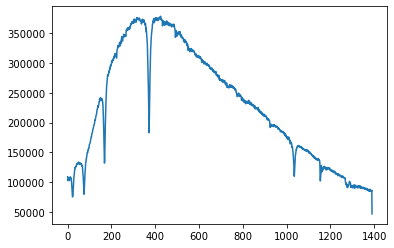

In [157]:
import matplotlib.pyplot as plt
vega_sum = np.sum(vega_light - bias_master, axis=0)
#plt.plot(vega_sum/np.max(vega_sum))
plt.plot(vega_sum)
vega_sum[424]

In [85]:
# From ijking.ipynb
slope = 2.57550836 * .1 # convert from angstrom to nm.
intercept = 3888.85008 * .1 # convert from angstrom to nm.
def pixels_to_wavelenghts(pixels, slope, intercept):
    '''
    This function converts pixel values to wavelengths using a linear model to be determined by a fit.
    '''
    return slope * pixels + intercept
pixels = np.array(range(len(vega_sum)))
wavelengths = pixels_to_wavelenghts(pixels, slope, intercept)
len(wavelengths)

1391

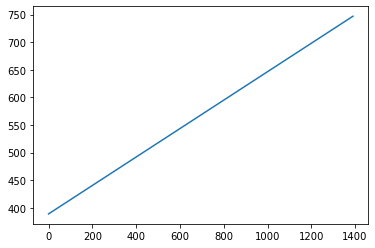

In [86]:
plt.plot(wavelengths)

In [139]:
list_wavelengths = []
for i in wavelengths:
    k = i / (10**9)
    list_wavelengths.append(k)

list_vega = []
for i in vega_sum:
    k = i/np.max(vega_sum)
    list_vega.append(k)

Text(0, 0.5, 'Relative spectral irradiance $Wm^{-2}nm^{-1}$')

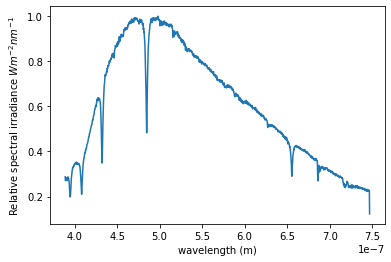

In [156]:
plt.plot(list_wavelengths, list_vega)
plt.xlabel('wavelength (m)')
plt.ylabel('Relative spectral irradiance $Wm^{-2}nm^{-1}$')

In [143]:
from lmfit import models
import scipy.constants as sc
import astropy.constants as ac

R_vega = 1.6 * (10**9)
d_vega = 25.05 * (9.46*(10**15))

planck_curve = lambda wavelength, temperature: ((R_vega/d_vega)**2)*( 2 * sc.Planck * (sc.speed_of_light ** 2) ) / ( (wavelength**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( wavelength * sc.k * temperature ) ) - 1 ) )
model_curve = models.Model(planck_curve, name='fit')
fit = model_curve.fit(list_vega, wavelength=list_wavelengths, temperature=9600)
fit

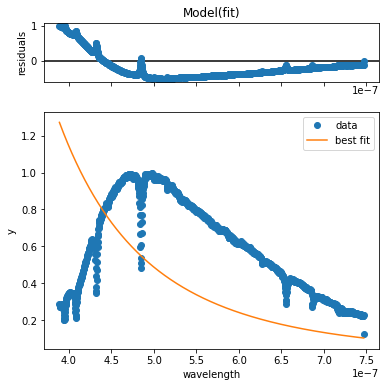

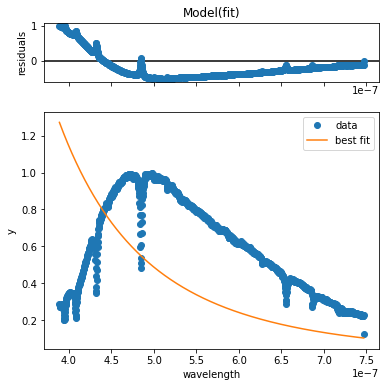

In [144]:
fit.plot()

In [135]:
S = []
temp = 9600
test_wavelength = np.arange(1, 2000, 1)
test_wavelength_nm = [ x / (10**9) for x in test_wavelength]
for i in test_wavelength_nm:
    mini_S = ((R_vega/d_vega)**2)*( 2 * sc.Planck * (sc.speed_of_light ** 2) ) / ( (i**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( i * sc.k * temp ) ) - 1 ) )
    S.append(mini_S)
mini_S

0.00015235907712809275

Text(0, 0.5, 'Relative spectral irradiance $Wm^{-2}nm^{-1}$')

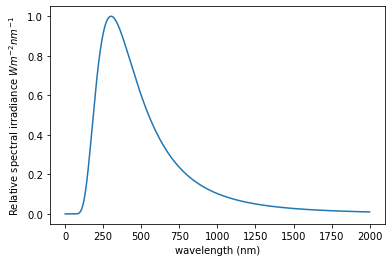

In [138]:
plt.plot(test_wavelength, (S/np.max(S)))
plt.xlabel('wavelength (nm)')
plt.ylabel('Relative spectral irradiance $Wm^{-2}nm^{-1}$')

Getting rid of absorption lines

In [145]:
from scipy.signal import find_peaks, peak_prominences
peaks, _ = find_peaks(vega_sum)
peaks

array([   4,    6,   12,   15,   34,   39,   42,   44,   47,   50,   54,
         56,   58,   62,   67,   90,   93,  125,  139,  146,  150,  156,
        183,  189,  192,  195,  197,  201,  204,  206,  209,  213,  215,
        218,  221,  229,  233,  237,  239,  241,  243,  247,  256,  258,
        262,  264,  268,  270,  272,  274,  279,  281,  283,  287,  290,
        295,  299,  303,  306,  309,  311,  316,  318,  320,  323,  326,
        328,  333,  336,  341,  344,  347,  349,  355,  358,  360,  390,
        393,  399,  402,  404,  409,  412,  415,  418,  421,  424,  428,
        430,  437,  440,  444,  447,  452,  456,  460,  462,  465,  467,
        471,  474,  477,  482,  484,  486,  496,  499,  501,  504,  506,
        510,  513,  516,  520,  525,  527,  532,  535,  539,  542,  545,
        548,  551,  554,  556,  560,  565,  567,  569,  572,  578,  583,
        586,  591,  594,  596,  599,  601,  605,  607,  610,  612,  614,
        616,  619,  621,  625,  628,  632,  635,  6

In [146]:
prominences = peak_prominences(vega_sum, peaks)[0]
prominences

array([3.64000e+02, 4.96900e+03, 6.43800e+03, 6.44000e+02, 8.74000e+02,
       1.63000e+02, 4.19000e+02, 8.00000e+02, 3.43000e+02, 5.41710e+04,
       1.42700e+03, 2.16400e+03, 5.56000e+02, 8.10000e+02, 1.80000e+02,
       7.31000e+02, 3.55000e+02, 6.81000e+02, 2.05300e+03, 2.08300e+03,
       1.10065e+05, 3.47700e+03, 2.77600e+03, 2.09700e+03, 1.49300e+03,
       2.74000e+02, 1.18300e+03, 2.23700e+03, 1.07100e+03, 4.64000e+02,
       1.13200e+03, 1.41300e+03, 3.08400e+03, 1.26700e+03, 7.86200e+03,
       2.83400e+03, 1.54800e+03, 5.60000e+03, 2.61300e+03, 3.53100e+03,
       1.31000e+02, 7.46700e+03, 4.41300e+03, 2.57800e+03, 2.76600e+03,
       1.51000e+03, 1.23100e+03, 1.04800e+03, 3.88000e+02, 2.79100e+03,
       2.69600e+03, 9.22000e+02, 1.71500e+03, 5.19000e+02, 1.25900e+03,
       3.21700e+03, 3.08400e+03, 5.56600e+03, 4.93500e+03, 7.92000e+02,
       3.61300e+03, 2.06100e+03, 1.93663e+05, 2.22000e+02, 1.20700e+03,
       2.99300e+03, 1.16500e+03, 1.15700e+03, 7.79000e+02, 8.250

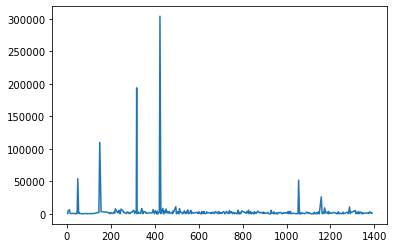

In [147]:
plt.plot(peaks, prominences)

In [151]:
filtered_peaks = []
filtered_pixel = []
n=0
k=0
for i in prominences:
    if i > 15000:
        j = peaks[n]
        filtered_peaks.append(j)
        filtered_pixel.append(i)

    n+=1

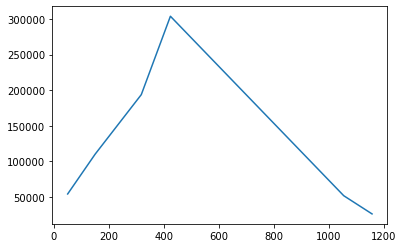

In [152]:
plt.plot(filtered_peaks, filtered_pixel)

In [154]:
filtered_peaks

[50, 150, 318, 424, 1055, 1158]

new approach

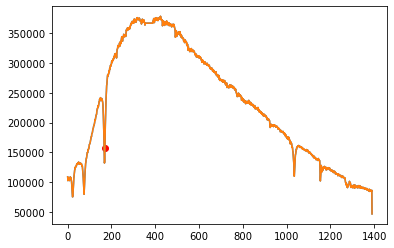

In [179]:
xx = [355, 390]
yy = [vega_sum[355], vega_sum[390]]
plt.plot(vega_sum)
plt.scatter(x, y, color='red')

outside_average = (vega_sum[354] + vega_sum[391])/2

for i in range(355, 390, 1):
    vega_sum[i] = outside_average

plt.plot(vega_sum)

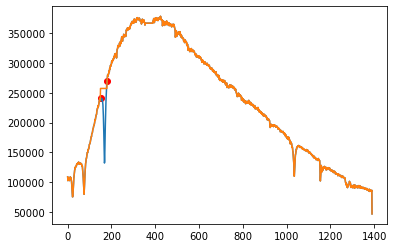

In [186]:
xx = [150, 180]
yy = [vega_sum[150], vega_sum[180]]
plt.plot(vega_sum)
plt.scatter(xx, yy, color='red')

outside_average = (vega_sum[149] + vega_sum[181])/2

for i in range(150, 180, 1):
    vega_sum[i] = outside_average

plt.plot(vega_sum)

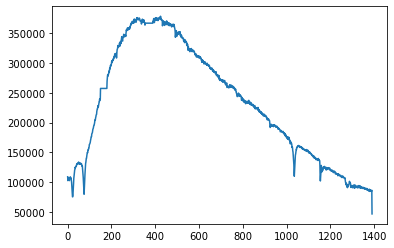

In [187]:
plt.plot(vega_sum)

In [178]:
x = []
y = []
for n in range(len(vega_sum)):
    lower = vega_sum[n-1]
    base = vega_sum[n]
    higher = vega_sum[n+1]
    lower_dif = abs(base - lower)
    higher_dif = abs(higher - base)
    if lower_dif > 20000:
        if higher_dif > 20000:
            print(vega_sum[n])
            x.append(n)
            print(n)
            y.append(vega_sum[n])
plt.plot(x, y, color='red')

157654.0
170


IndexError: index 1391 is out of bounds for axis 0 with size 1391